# 0. Download dataset

In [1]:
# https://drive.google.com/file/d/1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV/view
!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
!unzip -q icdar2003.zip -d datasets

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=d62f2254-99b7-4be2-a1fc-363ac8db1d5c
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 105MB/s]


# 1. Import libraries

In [5]:
!pip install ultralytics

  Using cached ultralytics-8.3.96-py3-none-any.whl.metadata (35 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

In [6]:
import ultralytics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
ultralytics.checks()

Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.2/112.6 GB disk)


In [8]:
import os
import shutil
import xml.etree.ElementTree as ET
import yaml

from sklearn.model_selection import train_test_split

# 2. Extract Data from XML and Store in YOLO format

In [9]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        # Store
        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [10]:
dataset_dir = "datasets/SceneTrialTrain"
words_xml_path = os.path.join(dataset_dir, "words.xml")
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(
    words_xml_path
)

In [11]:
print(f"Number of images: {len(image_paths)}")
print(f"Example image path: {image_paths[0]}")
print(f"Example image size: {image_sizes[0]}")
print(f"Example bounding boxes: {bounding_boxes[0][:2]}")
print(f"Example labels: {image_labels[0][:2]}")

Number of images: 250
Example image path: apanar_06.08.2002/IMG_1261.JPG
Example image size: (1600, 1200)
Example bounding boxes: [[174.0, 392.0, 274.0, 195.0], [512.0, 391.0, 679.0, 183.0]]
Example labels: ['self', 'adhesive']


# 3. Convert to YOLO format

In [12]:
def convert_to_yolo_format(image_paths, image_sizes, bounding_boxes):
    yolo_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        yolo_labels = []

        for bbox in bboxes:
            x, y, w, h = bbox

            # Calculate normalized bounding box coordinates
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            # Because we only have one class, we set class_id to 0
            class_id = 0

            # Convert to YOLO format
            yolo_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolo_labels.append(yolo_label)

        yolo_data.append((image_path, yolo_labels))

    return yolo_data

In [13]:
# Define class labels
class_labels = ["text"]

# Convert data into YOLO format
yolo_data = convert_to_yolo_format(image_paths, image_sizes, bounding_boxes)

# 4. Train, val, test split

In [14]:
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True
train_data, test_data = train_test_split(
    yolo_data,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle,
)
test_data, val_data = train_test_split(
    test_data,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle,
)

# 5. Save data

In [15]:
def save_data(data, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(save_dir, "labels"), exist_ok=True)

    for image_path, yolo_labels in data:
        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, image_path), os.path.join(save_dir, "images")
        )

        # Save labels to labels folder
        image_name = os.path.basename(image_path)
        image_name = os.path.splitext(image_name)[0]

        with open(os.path.join(save_dir, "labels", f"{image_name}.txt"), "w") as f:
            for label in yolo_labels:
                f.write(f"{label}\n")

In [16]:
save_yolo_data_dir = "datasets/yolo_data"
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, "train")
save_val_dir = os.path.join(save_yolo_data_dir, "val")
save_test_dir = os.path.join(save_yolo_data_dir, "test")

save_data(train_data, dataset_dir, save_train_dir)
save_data(test_data, dataset_dir, save_val_dir)
save_data(val_data, dataset_dir, save_test_dir)

# 6. Create yaml file

In [17]:
data_yaml = {
    "path": "./yolo_data",
    "train": "train/images",
    "test": "test/images",
    "val": "val/images",
    "nc": 1,
    "names": class_labels,
}

yolo_yaml_path = os.path.join(save_yolo_data_dir, "data.yml")
with open(yolo_yaml_path, "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

# 7. Training

In [18]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11m.pt")

# Train model
results = model.train(
    data=yolo_yaml_path,
    epochs=100,
    imgsz=640,
    cache=True,
    patience=20,
    plots=True,
)

100%|██████████| 38.8M/38.8M [00:00<00:00, 424MB/s]


Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=datasets/yolo_data/data.yml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 56.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 321MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1547.03it/s]

train: New cache created: /content/datasets/yolo_data/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 200/200 [00:01<00:00, 186.87it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/yolo_data/val/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 1270.72it/s]

val: New cache created: /content/datasets/yolo_data/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 43/43 [00:00<00:00, 96.64it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.04G      1.911      2.778      1.712         28        640: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         43        200      0.343       0.43      0.344      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       8.6G      1.242      1.336       1.15         81        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.561       0.65      0.569      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.69G      1.205      1.228       1.18         30        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         43        200      0.213       0.47      0.193     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.73G      1.311      1.297      1.232         37        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


                   all         43        200   0.000893       0.05   0.000422   0.000123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.82G      1.384      1.328      1.286         34        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         43        200   0.000158       0.01   7.94e-05   2.01e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.89G        1.3      1.298      1.208         47        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         43        200   7.97e-05      0.005   3.91e-05   3.91e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.96G      1.334      1.286      1.252         34        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         43        200    0.00641       0.16     0.0037    0.00107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.02G      1.413      1.304      1.275         79        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200       0.39      0.465      0.341      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.06G      1.352      1.243      1.254         53        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.426      0.445      0.341      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.15G      1.337      1.176      1.206         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         43        200      0.327      0.785      0.454       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.22G      1.291      1.121      1.237         29        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         43        200      0.147      0.515      0.134       0.08



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.29G      1.317      1.114      1.224         61        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         43        200     0.0741      0.055     0.0141    0.00592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.33G      1.278      1.087      1.189         43        640: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         43        200     0.0768     0.0483     0.0141    0.00614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.42G       1.26      1.115      1.183         30        640: 100%|██████████| 13/13 [00:06<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         43        200      0.161      0.125     0.0514     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.57G      1.224      1.011      1.135         82        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         43        200     0.0731      0.055     0.0133    0.00502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.64G      1.204      1.042      1.184         45        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         43        200      0.475      0.575      0.436      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.68G      1.163      0.987      1.137         59        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.643       0.74      0.672      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.77G      1.165      1.017      1.137         62        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.632       0.75      0.657      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       9.9G      1.109     0.9386      1.098         54        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         43        200      0.805      0.725      0.782        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      10.1G      1.098     0.9237      1.101         76        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.651      0.811      0.711      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      10.1G      1.046     0.8911      1.078         74        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         43        200      0.739      0.809      0.826      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      10.3G      1.157     0.9492      1.125         93        640: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         43        200      0.769      0.815      0.782      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      10.5G       1.06     0.8579      1.067         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.758       0.81      0.793      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      10.5G      1.119     0.8774      1.085         52        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.805      0.762      0.779      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      10.6G      1.035      0.811      1.056         65        640: 100%|██████████| 13/13 [00:06<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


                   all         43        200      0.778      0.785      0.759      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      10.7G      1.042     0.8039      1.073         49        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.777      0.799      0.788      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      10.8G     0.9816     0.8138       1.08         30        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        200      0.782      0.827      0.804      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      10.9G      1.011     0.8089      1.056         41        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         43        200      0.807      0.838       0.84      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100        11G      1.042       0.87      1.086         58        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         43        200      0.785      0.805      0.839      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      11.1G     0.9915     0.8109      1.062         34        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.793      0.825      0.825      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      11.2G     0.9865     0.7925      1.062         30        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         43        200      0.844      0.805      0.848        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      11.4G     0.9577     0.7481       1.04         67        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.808       0.81        0.8      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      11.5G       0.97     0.7461      1.041         63        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.827      0.835      0.853      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      11.7G      1.006     0.8027      1.078         87        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


                   all         43        200       0.78      0.815      0.842      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      11.8G     0.9303     0.7528      1.036         42        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200       0.81       0.87      0.864      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.2G     0.9528     0.7487      1.032         35        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.853      0.765      0.852      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      12.3G     0.9198     0.7313      1.031         31        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         43        200      0.853      0.865      0.873      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.4G     0.9516     0.7047      1.028         54        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.794      0.855      0.846      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.4G     0.9362     0.7299      1.035         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.812       0.86      0.885      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.5G     0.9319     0.7132      1.028         73        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         43        200      0.807      0.865      0.874      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.5G     0.8997     0.6926       1.02         46        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.841       0.87      0.904      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      12.6G      0.907     0.6941      1.011         66        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.855      0.865      0.879      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.7G      0.888     0.6803      1.006         43        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        200      0.833      0.846      0.869      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      12.8G     0.9085     0.6746      1.017         46        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.817      0.835      0.863      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.9G     0.8557     0.6503     0.9862         41        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.819      0.836      0.865      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.1G     0.8676     0.6506      1.006         44        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        200      0.783        0.9      0.877      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.1G     0.8618     0.6389     0.9965         36        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.826       0.82      0.853      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.2G     0.8566     0.6346     0.9998        102        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        200      0.862      0.905      0.907       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.3G      0.862     0.6507     0.9977         48        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         43        200      0.816      0.866      0.899      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      8.59G     0.8511     0.6235     0.9912         70        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         43        200      0.873      0.865      0.906      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.08G     0.8267     0.6264      0.978         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.808       0.93      0.913      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.08G     0.8305     0.6143     0.9972         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         43        200      0.875      0.876       0.91      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.08G     0.7638      0.559     0.9633         61        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.881      0.885      0.894      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.08G      0.816     0.5888     0.9849         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        200      0.885      0.875      0.897      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.08G     0.8011     0.5946     0.9664         37        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         43        200      0.885       0.85      0.899      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.08G     0.8035     0.5948     0.9665         31        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.855      0.865      0.887      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.08G     0.8526     0.5985      0.991         61        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.882       0.82      0.902      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.12G     0.8006     0.5811     0.9847         62        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         43        200      0.871      0.912      0.919      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.19G     0.7672     0.5622      0.951         43        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         43        200      0.839      0.909      0.915      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.25G     0.7491      0.531     0.9627         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         43        200       0.82       0.89      0.892      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.29G     0.7647     0.5391     0.9721         63        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         43        200      0.853      0.935       0.91      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.38G     0.7877     0.5684      0.982         33        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.889      0.882      0.922      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.45G     0.7588     0.5526     0.9586         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.864      0.895      0.904       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.52G     0.7596     0.5374       0.95         64        640: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         43        200      0.869      0.895      0.901      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.56G     0.7505      0.545     0.9476         41        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         43        200      0.901       0.88      0.908       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.65G     0.7631     0.5362     0.9603         80        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.916      0.895      0.911      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.72G     0.7383     0.5273     0.9468         50        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         43        200      0.898      0.882      0.903      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.78G     0.7643     0.5412     0.9562         75        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.913       0.85      0.909      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.83G     0.7198     0.5255     0.9466         42        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.909      0.848      0.916      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.99G     0.7383     0.5334     0.9546         42        640: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         43        200      0.882      0.899      0.914      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      10.1G     0.7559     0.5239     0.9671         34        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         43        200      0.892      0.865      0.913       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      10.2G     0.7463     0.5355     0.9676         51        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         43        200      0.888       0.91      0.922      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      10.3G     0.7191     0.5247      0.952         69        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         43        200      0.876      0.916      0.925      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      10.4G     0.7213     0.5346     0.9685         33        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.893       0.93      0.921      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      10.5G     0.7063     0.4944     0.9514         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        200      0.893       0.92      0.925      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100        11G     0.7018     0.4923     0.9437         50        640: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         43        200      0.913      0.888      0.918      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.1G     0.6809     0.4883      0.933         61        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.902       0.92      0.921      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      11.2G       0.69     0.4799     0.9307         53        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         43        200      0.887        0.9      0.907      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      11.2G     0.6906     0.4653     0.9144         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         43        200      0.879       0.89      0.904      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      11.3G     0.6422     0.4525     0.9191         54        640: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.882       0.89      0.905      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      11.3G     0.6654     0.4688     0.9288         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.877        0.9      0.912      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      11.4G     0.6882     0.4671     0.9233         94        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


                   all         43        200       0.89      0.892      0.919      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.5G     0.6841     0.4857     0.9374         67        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.881      0.915      0.919      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      11.7G     0.6725      0.463     0.9271         58        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         43        200      0.884      0.925      0.924      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      11.7G     0.6517     0.4585      0.927         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         43        200      0.917       0.89      0.921      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      11.8G     0.6441      0.453     0.9164         61        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         43        200      0.913      0.889       0.93      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      11.9G     0.6649     0.4578       0.93         45        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         43        200      0.912       0.89      0.934      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      11.9G     0.6229     0.4528     0.9197         72        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


                   all         43        200      0.913      0.896      0.935      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      12.1G      0.626     0.4328     0.9071         51        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         43        200      0.911      0.918      0.931      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      12.2G     0.6111     0.4229     0.9016         70        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         43        200       0.88       0.93      0.931      0.714


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      12.3G     0.6938     0.5131     0.9182         47        640: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.889      0.925      0.928      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      12.4G     0.6966     0.5131     0.9263         50        640: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         43        200      0.902      0.923      0.932      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      12.5G     0.6687     0.4916     0.9201         19        640: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.913      0.915      0.932      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      12.6G     0.6443     0.4732     0.9091         54        640: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         43        200      0.893      0.915      0.925      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      12.8G      0.658     0.4756      0.914         26        640: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.882      0.925      0.923      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      12.9G     0.6328     0.4587     0.9039         22        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         43        200      0.924       0.91      0.929       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      12.9G     0.6385     0.4369     0.8955         33        640: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.894       0.93      0.932      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      13.1G     0.6434     0.4495     0.9089         33        640: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         43        200      0.916      0.915      0.932      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      13.2G     0.6324     0.4537      0.901         18        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         43        200      0.923      0.915      0.932      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      13.3G     0.6207     0.4426     0.8904         36        640: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         43        200      0.916      0.905      0.932      0.721



100 epochs completed in 0.237 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]


                   all         43        200      0.913       0.89      0.934      0.731
Speed: 0.2ms preprocess, 8.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train


# 8. Evaluation

In [19]:
model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)

metrics = model.val()

Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


                   all         43        200      0.912       0.89      0.934       0.73
Speed: 6.0ms preprocess, 23.9ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val


# 9. Inference

In [20]:
import json

import cv2
import matplotlib.pyplot as plt


def visualize_bbox(
    img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction["confidence"]

        if conf_score < conf_thres:
            continue

        bbox = prediction["box"]
        xmin = int(bbox["x1"])
        ymin = int(bbox["y1"])
        xmax = int(bbox["x2"])
        ymax = int(bbox["y2"])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(
            img,
            (xmin, ymin - text_height - 5),
            (xmin + text_width, ymin),
            (0, 255, 0),
            -1,
        )
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

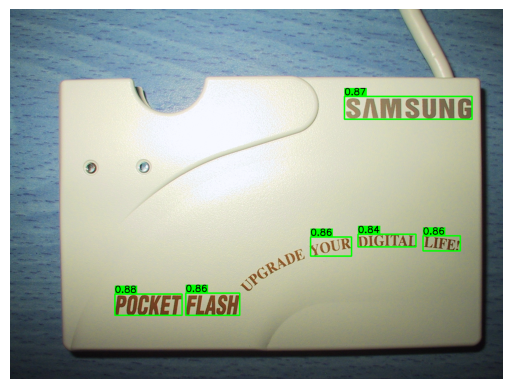

In [21]:
model_path = "runs/detect/train/weights/best.pt"
img_path = "datasets/SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG"
conf_thres = 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
predictions = json.loads(results[0].to_json())
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis("off")
plt.show()